In [257]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [258]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

import pandas as pd

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import read_topology, TopologyNode
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree, plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.statistics import gelman_rubin
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm

In [259]:
# seed,
seed = 42
#import os; seed = int(os.urandom(5).hex(), 16)
key = PRNGKey(seed)

In [260]:
import pandas as pd

HypTree(size=33, levels=7, leaves=17, inner nodes=15)
                                                                                                                                   
                                     ┌────────────────────────────────────────────────────────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────┐
                                                                                                                                                                                                                                                                                         
      ┌──────────────────────────────┴───────────────────────────────┐                                                                                                                  ┌───────────────────────────────────────┴───────────────────────────────────────┐                
Papilio_gigon           

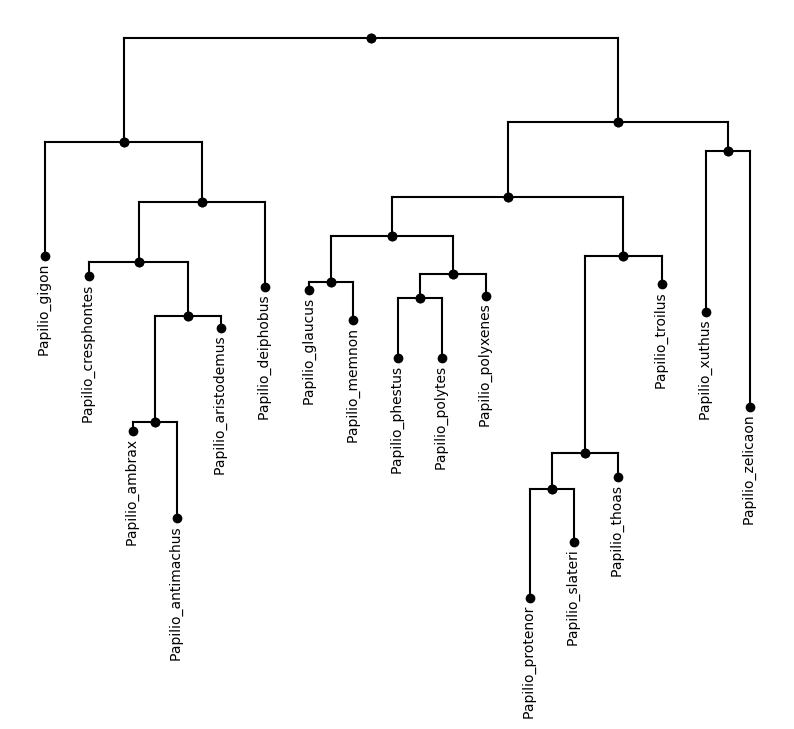

In [261]:


# data and landmarks dimensions
d=2

filename = "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/papilio_male_dataset/papilio_tree.tree"
filename_csv = "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/papilio_male_dataset/papilio_shapes.csv"
#filename = "hyperiax_internal_data/data/butterflies/male_dataset/species_tree.tre"
#filename_csv = "hyperiax_internal_data/data/butterflies/male_dataset/reconstructed_shapes.csv"
with open(filename, "r") as file:
    string_tree = file.read()
tree = read_topology(string_tree)

# print the tree
print(tree)
plot_tree_text(tree)
plot_tree(tree,inc_names=True)

n landmarks:  118
n landmarks after removing coinciding landmarks:  (33, 234)


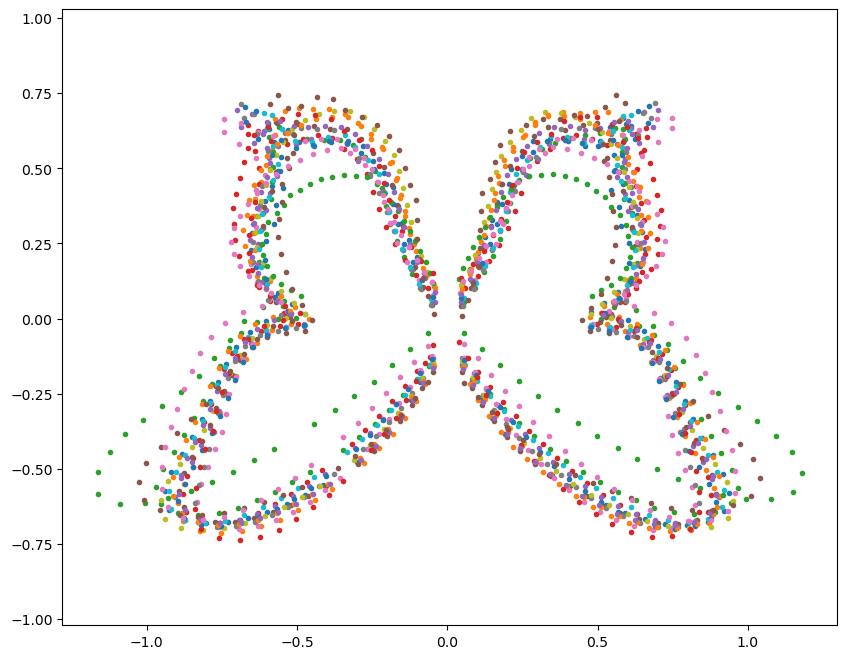

In [262]:
n_steps = 25

landmarks_edges = pd.read_csv(filename_csv, sep=",", header = 0)
node_names = landmarks_edges['node_names'] 
landmarks_edges = landmarks_edges.set_index('node_names')
landmarks = landmarks_edges.drop(columns="edges")
landmarks = landmarks.to_numpy()

# Check for NaN values in landmarks array
nan_rows = jnp.where(jnp.isnan(landmarks).any(axis=1))[0]
if len(nan_rows) > 0:
    print("Warning: NaN values found in landmarks array at row(s):", nan_rows)
n = landmarks.shape[1]//d
print("n landmarks: ",n)
if 'male_dataset' in filename_csv:
    landmarks = landmarks.reshape((-1,n,d))
    landmarks = jnp.delete(landmarks,66,axis=1) # drop row with coinciding landmarks
    landmarks = landmarks.reshape((landmarks.shape[0],-1))
    n = landmarks.shape[1]//d
    print("n landmarks after removing coinciding landmarks: ",landmarks.shape)

n_shapes = landmarks.shape[0]
landmarks = 2*1e-3*landmarks.reshape((n_shapes,-1,d))[:,::1].reshape((n_shapes,-1))

# add landmarks to tree 
tree.add_property('value', shape=(n_steps+1,n*d,))

tree.data['value'] = tree.data['value'].at[:].set(landmarks[:,None,:])
leaf_values = tree.data['value'][tree.is_leaf][:,-1]

fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(tree.data['value'][leaf.id][-1],ax=ax)
       
for i,node in enumerate(tree.iter_topology_bfs()):
    node.name = node_names[i]
    
my_nodenames_leaves = []    
leaves_parents = []
for node in tree.iter_topology_leaves_bfs():  
    my_nodenames_leaves.append(node.name) 
    leaves_parents.append(node.parent.name)

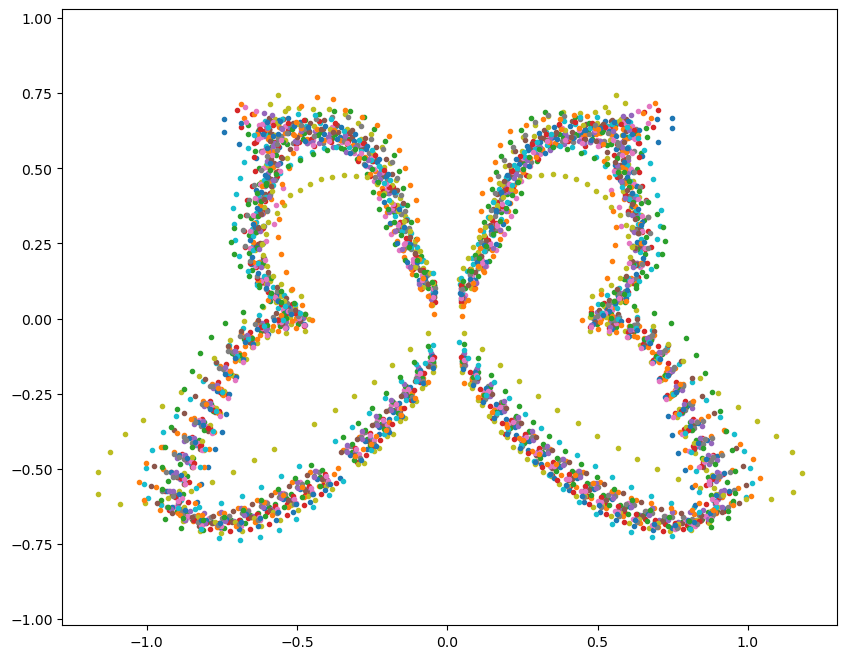

In [263]:
fig,ax = plt.subplots(figsize=(10,8))
for node in tree.iter_topology_bfs():
    plot_shape_2d(tree.data['value'][node.id][-1],ax=ax)
    
my_nodenames = []    
for node in tree.iter_topology_bfs():  
    my_nodenames.append(node.name)    

In [264]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)
components = pca.fit_transform(leaf_values)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2),
    color=my_nodenames_leaves  
)

fig.update_traces(diagonal_visible=False)
fig.show()

[0.62567712 0.18449844]
[2.15211029 1.16865342]


In [265]:
# pca = PCA(n_components=3)
# components_leaves = pca.fit_transform(leaf_values)
# components_all = pca.fit_transform(tree.data['value'][:,-1])

# total_var = pca.explained_variance_ratio_.sum() * 100

# fig = px.scatter_3d(
#     components_leaves, x=0, y=1, z=2, color=leaves_parents,
#     title=f'Total Explained Variance: {total_var:.2f}%',
#     labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
# )

# fig.show() 

In [266]:
import numpy as np

X_mean = np.mean(leaf_values, axis=0)

# Generate new random shape using eigenvectors
b = np.random.normal(0, np.sqrt(pca.explained_variance_), size=(5,))
X_new = X_mean + np.dot(b, pca.components_)

# Reshape to (x, y) pairs for visualization
X_mean_reshaped = X_mean.reshape(n, 2)
X_new_reshaped = X_new.reshape(n, 2)

# Flip the data on the y-axis by negating the second column (the y-values)
X_mean_reshaped = X_mean_reshaped.at[:, 1].set(X_mean_reshaped[:, 1]*-1)
X_new_reshaped = X_new_reshaped.at[:, 1].set(X_new_reshaped[:, 1]*-1)

# Plot original mean shape and new synthesized shape
plt.figure(figsize=(6, 6))
plt.scatter(X_mean_reshaped[:, 0], X_mean_reshaped[:, 1], label="Mean Shape", marker="o", color="blue")
plt.scatter(X_new_reshaped[:, 0], X_new_reshaped[:, 1], label="Generated Shape", marker="x", color="red")

for i in range(n):
    plt.plot([X_mean_reshaped[i, 0], X_new_reshaped[i, 0]], 
             [X_mean_reshaped[i, 1], X_new_reshaped[i, 1]], 'k--', alpha=0.5)

plt.legend()
plt.title("Generated Landmark Shape Using PCA")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 2 with shape (2,).

In [ ]:
def __PCA(data):
    # P = (n − 1)^{-1} · (X − mean[X])^T · (X − mean[X])
    mean = np.mean(data, axis=0, keepdims=True)
    data_cent = (data - mean).T
    cov_matrix = np.cov(data_cent)
    # Extract eigenvalues and eigenvectors
    w, v = np.linalg.eigh(cov_matrix)
    PCevals = w[::-1]
    PCevecs = v[:,::-1]
    return PCevals, -PCevecs, mean

def __transformData(features, PCevecs, mean, dims):
    # S = (X − mean[X]) · U
    centered_features = features - mean  
    return np.dot(centered_features, PCevecs[:, 0:dims])

PCevals, PCevecs, mean = __PCA(leaf_values)
trainingFeatures2D = __transformData(leaf_values, PCevecs, mean, 2)

print(PCevals)


[ 2.89473669e-01  8.53594263e-02  5.73348117e-02  1.30096989e-02
  6.88243471e-03  3.73331091e-03  2.02457019e-03  1.23066252e-03
  9.18538630e-04  7.29720221e-04  5.84931605e-04  4.67673487e-04
  4.30508173e-04  2.33623000e-04  1.66548874e-04  7.65039890e-05
  1.03686673e-16  6.00961864e-17  5.47660970e-17  4.43382439e-17
  3.82937645e-17  2.86442453e-17  2.45374451e-17  2.04407724e-17
  2.03773293e-17  1.83761599e-17  1.67659495e-17  1.45063816e-17
  1.28754422e-17  1.18736468e-17  1.17579731e-17  1.14756891e-17
  1.03144205e-17  9.38329487e-18  9.03924110e-18  8.52470226e-18
  8.40366151e-18  7.51815239e-18  7.43255284e-18  7.14116402e-18
  6.60103165e-18  6.55949402e-18  6.47818345e-18  5.91667919e-18
  5.85812805e-18  5.67933124e-18  5.44283128e-18  5.07698013e-18
  4.96608968e-18  4.93744930e-18  4.87975002e-18  4.76841089e-18
  4.47096922e-18  4.24087779e-18  3.90992330e-18  3.73419639e-18
  3.49540224e-18  3.42212448e-18  3.21409326e-18  3.14855728e-18
  3.13849824e-18  2.90153

In [ ]:
fig = px.scatter_matrix(
    trainingFeatures2D,
    dimensions=range(2),
    color=my_nodenames_leaves  
)

fig.update_traces(diagonal_visible=False)


fig.show()

In [ ]:
def generate_C(tree):

    # Add cumulative edge lengths and level to tree
    tree.add_property('level', shape=(1,))
    tree.add_property('cum_sum_edge_length', shape=(1,))
        
    @jax.jit
    def down(edge_length, parent_cum_sum_edge_length, parent_level, **args):
        return {'cum_sum_edge_length': edge_length + parent_cum_sum_edge_length, 'level' : 1 + parent_level}

    downmodel = DownLambda(down_fn=down)

    exe = OrderedExecutor(downmodel)

    exe.down(tree)

    # Generate C matrix
    
    n_leaves = len(tree.data['value'][tree.is_leaf])

    C = np.zeros((n_leaves,n_leaves),int)

    """ def compute_edge_lengths(node:TopologyNode):
        lengths = []
        def rec(n):
            lengths.append(n.data['edge_length'])
            if n.parent!=None:
                rec(n.parent)
        rec(node)
        return sum(lengths) """
        
    def get_edge_lengths(a:TopologyNode):
        if tree.data['cum_sum_edge_length'][a.id][0] != 0:
            cum_sum = tree.data['cum_sum_edge_length'][a.id][0] + tree.data['edge_length'][0][0]
            return cum_sum
        else: 
            return 0

    # def find_shared_edge_lengths(a:TopologyNode, b:TopologyNode, i:int, j:int):
    #         # If node a and b is the same node, compute length from the node to the root
    #         if (a.name==b.name):
    #             C[i,j] = get_edge_lengths(a)
    #         # If not, look at parent nodes if they exist 
    #         elif (a.name!=b.name and a.parent!=None and b.parent!=None):
    #             # If node a and b is not the same node, but share the same parent, compute length from parent node to root
    #             if (a.parent.name==b.parent.name):
    #                 C[i,j] = get_edge_lengths(a.parent) 
    #             # If node a and b is not the same and they don't share a parent, go one level up
    #             if (a.parent.name!=b.parent.name):
    #                 # If a is a deeper level than b
    #                 if tree.data['level'][a.id][0] > tree.data['level'][b.id][0]:
    #                     find_shared_edge_lengths(a.parent,b,i,j)       
    #                 # If b is a deeper level than a
    #                 elif tree.data['level'][a.id][0] < tree.data['level'][b.id][0]:
    #                     find_shared_edge_lengths(a,b.parent,i,j)  
    #                 # If they are same level 
    #                 else:
    #                     find_shared_edge_lengths(a.parent,b.parent,i,j) 
    
    
    
    def find_shared_edge_lengths(a:TopologyNode, b:TopologyNode):
        # If the two nodes are on a different level, move one node a level up
        while tree.data['level'][a.id][0] > tree.data['level'][b.id][0]:
            a = a.parent
        while tree.data['level'][a.id][0] < tree.data['level'][b.id][0]:
            b = b.parent
        # If the nodes are on the same level but don't have the same parent, move both a level up 
        while a.name!=b.name:
            a = a.parent
            b = b.parent
                
        return get_edge_lengths(a)
            

    for i,a in enumerate(tree.iter_topology_leaves_bfs()):
        for j,b in enumerate(tree.iter_topology_leaves_bfs()):
                C[i,j] = find_shared_edge_lengths(a,b)
                
    return C
    
C = generate_C(tree) 

print(C)

    

[[ 51  26   0   0  26   0  26   0   0   0   0  26  26   0   0   0   0]
 [ 26  57   0   0  39   0  39   0   0   0   0  39  39   0   0   0   0]
 [  0   0  63  28   0  22   0  22  22  22  22   0   0  22  22  22  22]
 [  0   0  28  83   0  22   0  22  22  22  22   0   0  22  22  22  22]
 [ 26  39   0   0  55   0  52   0   0   0   0  52  52   0   0   0   0]
 [  0   0  22  22   0  57   0  38  38  38  51   0   0  38  38  51  51]
 [ 26  39   0   0  52   0  66   0   0   0   0  64  64   0   0   0   0]
 [  0   0  22  22   0  38   0  58  56  46  38   0   0  46  46  38  38]
 [  0   0  22  22   0  38   0  56  65  46  38   0   0  46  46  38  38]
 [  0   0  22  22   0  38   0  46  46  59  38   0   0  55  55  38  38]
 [  0   0  22  22   0  51   0  38  38  38  99   0   0  38  38  93  93]
 [ 26  39   0   0  52   0  64   0   0   0   0  89  87   0   0   0   0]
 [ 26  39   0   0  52   0  64   0   0   0   0  87 108   0   0   0   0]
 [  0   0  22  22   0  38   0  46  46  55  38   0   0  73  60  38  38]
 [  0 

In [267]:
def phylo_PCA(tree, data):
    # Get phylogenetic covariance matrix
    C = generate_C(tree)
    n = C.shape[0]
    # Get estimated ancestral values
    # a = [(1^T · C^{-1} · 1)^{-1} · 1^T · C^{-1} · X]^T
    ones = np.ones((n,1))
    a = (np.linalg.inv(ones.T@np.linalg.inv(C)@ones)@ones.T@np.linalg.inv(C)@data).T
    # Get evolutionary covariance matrix
    # Pp = (n − 1)^{-1} · (X − a^T)^T · C^{-1} · (X − a^T)
    data_cent = (data - a.T)
    P = ((n-1)^(-1))*data_cent.T@np.linalg.inv(C)@data_cent
    # Extract eigenvalues and eigenvectors with SVD
    Up, Sp, Vh = np.linalg.svd(P)
    return Up, Sp, a

def transform_data(features, PCevecs, a):
    # Sp = (X-a) · Up
    centered_features = features - a.T 
    transformed_data = centered_features@PCevecs
    return transformed_data

Ppevecs, Ppevals, a = phylo_PCA(tree, leaf_values)
features = transform_data(leaf_values, Ppevecs, a)

fig = px.scatter_matrix(
    features,
    dimensions=range(2),
    color=my_nodenames_leaves  
)

fig.update_traces(diagonal_visible=False)

fig.show()


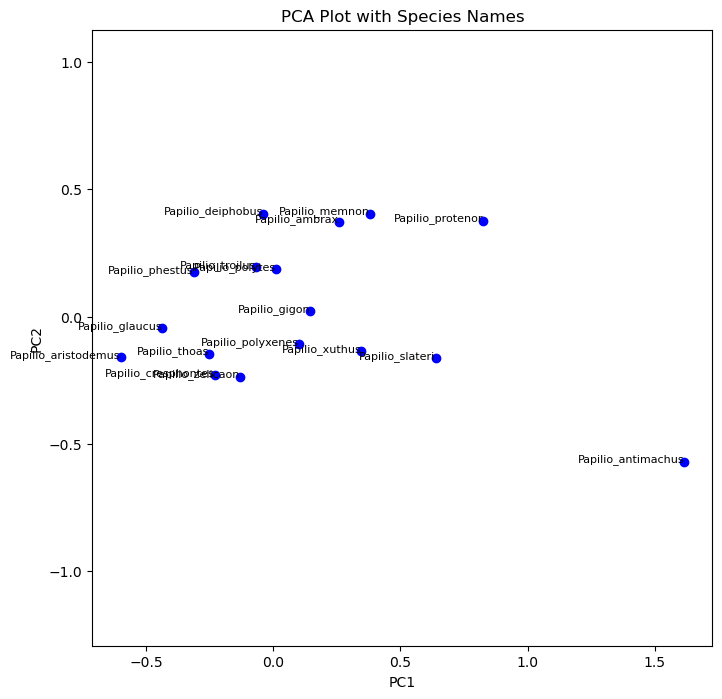

In [269]:

# My pPCA
# Plot the PCA data in 2D (first two principal components)
plt.figure(figsize=(8, 8))

# Scatter plot of the PCA-transformed data (you can change the number of components)
plt.scatter(features[:, 0], -features[:, 1], label="PCA Features", color="blue", marker="o")

# Add species names as labels on the points
for i, name in enumerate(my_nodenames_leaves):  # Assuming leaf_names contains species names corresponding to 'leaf_values'
    plt.text(features[i, 0], -features[i, 1], name, fontsize=8, color="black", ha='right')

# Customize the plot
plt.title("PCA Plot with Species Names")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.show()

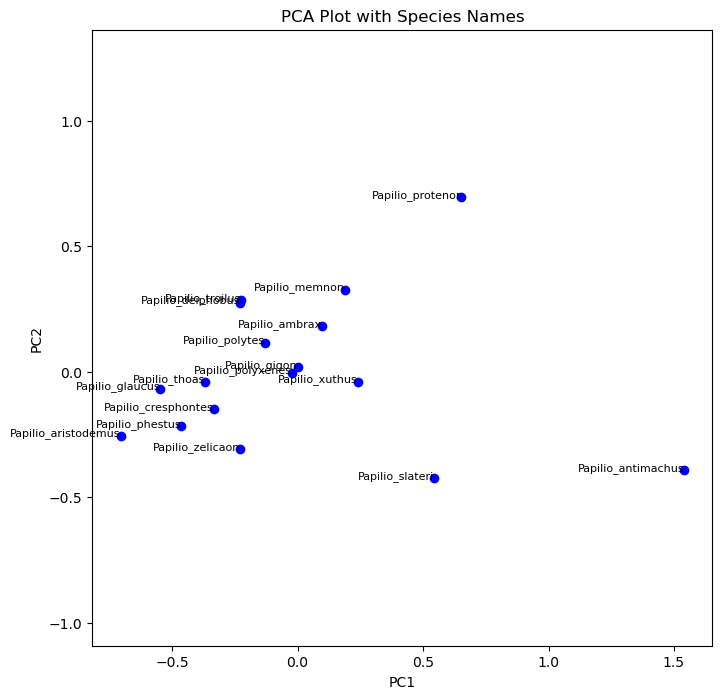

In [270]:
# My PCA
# Plot the PCA data in 2D (first two principal components)
plt.figure(figsize=(8, 8))

# Scatter plot of the PCA-transformed data (you can change the number of components)
plt.scatter(trainingFeatures2D[:, 0], trainingFeatures2D[:, 1], label="PCA Features", color="blue", marker="o")

# Add species names as labels on the points
for i, name in enumerate(my_nodenames_leaves):  # Assuming leaf_names contains species names corresponding to 'leaf_values'
    plt.text(trainingFeatures2D[i, 0], trainingFeatures2D[i, 1], name, fontsize=8, color="black", ha='right')

# Customize the plot
plt.title("PCA Plot with Species Names")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.show()

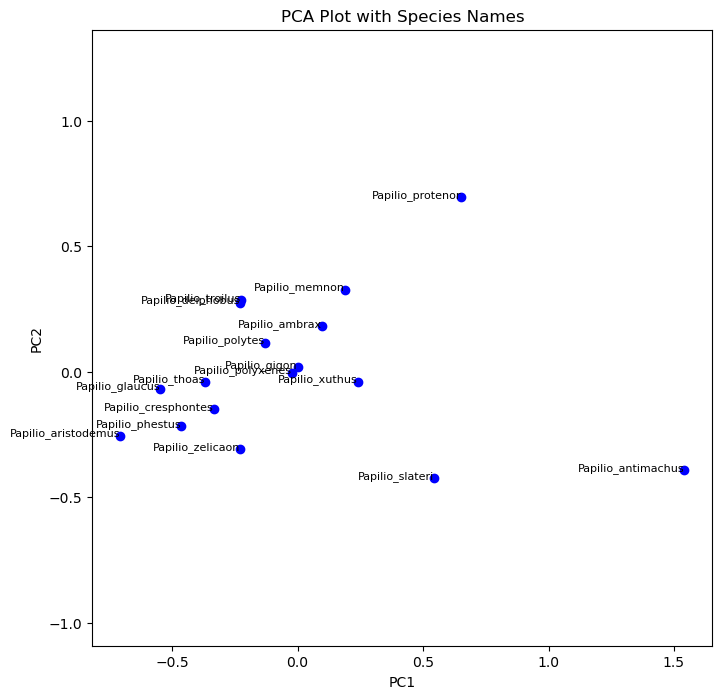

In [271]:
# SciKit learn PCA
# Plot the PCA data in 2D (first two principal components)
plt.figure(figsize=(8, 8))

# Scatter plot of the PCA-transformed data (you can change the number of components)
plt.scatter(components[:, 0], components[:, 1], label="PCA Features", color="blue", marker="o")

# Add species names as labels on the points
for i, name in enumerate(my_nodenames_leaves):  # Assuming leaf_names contains species names corresponding to 'leaf_values'
    plt.text(components[i, 0], components[i, 1], name, fontsize=8, color="black", ha='right')

# Customize the plot
plt.title("PCA Plot with Species Names")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.show()

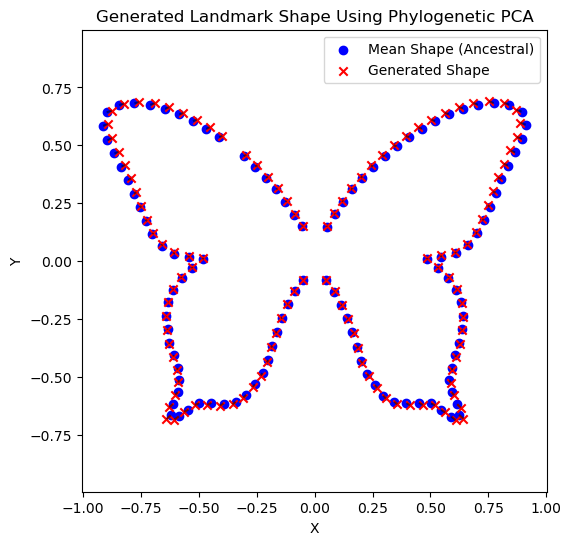

In [272]:
# Assuming you've already run phylo_PCA and obtained PCevecs, PCevals, and 'a' (ancestral vector)
# Use the ancestral vector 'a' instead of the mean of the original data
X_mean = a.T  # Use 'a' instead of the mean

# Number of principal components to sample from
num_components = 2  # You can adjust this value depending on how many components you want to use

# Sample from a normal distribution using the eigenvalues
b = np.random.normal(0, np.sqrt(PCevals[:num_components]), size=(num_components,))

# Generate the new data by adding the projection of the samples onto the selected principal components
X_new = X_mean + np.dot(b, PCevecs[:, :num_components].T)

# Now, reshape the original mean (ancestral vector) and the new shape for visualization (assuming 2D data)
n = X_mean.shape[1] // 2  # Number of landmarks, assuming 2D data
X_mean_reshaped = X_mean.reshape(n, 2)
X_new_reshaped = X_new.reshape(n, 2)

# Flip the data on the y-axis by negating the second column (the y-values)
X_mean_reshaped = X_mean_reshaped.at[:, 1].set(X_mean_reshaped[:, 1]*-1)
X_new_reshaped = X_new_reshaped.at[:, 1].set(X_new_reshaped[:, 1]*-1)

# Plot the original mean shape and the new generated shape
plt.figure(figsize=(6, 6))
plt.scatter(X_mean_reshaped[:, 0], X_mean_reshaped[:, 1], label="Mean Shape (Ancestral)", marker="o", color="blue")
plt.scatter(X_new_reshaped[:, 0], X_new_reshaped[:, 1], label="Generated Shape", marker="x", color="red")

# Connect the corresponding points with dashed lines
for i in range(n):
    plt.plot([X_mean_reshaped[i, 0], X_new_reshaped[i, 0]], 
             [X_mean_reshaped[i, 1], X_new_reshaped[i, 1]], 'k--', alpha=0.5)

plt.legend()
plt.title("Generated Landmark Shape Using Phylogenetic PCA")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

# To transform the new data back into the original phylogenetic PCA space:
# Assuming 'a' is the ancestral values and 'PCevecs' is the principal component matrix
X_new_transformed = transform_data(X_new.reshape(1, -1), PCevecs, a)

In [ ]:
tree.add_property('pca', shape=(1,))


['Papilio_gigon', 'Papilio_deiphobus', 'Papilio_xuthus', 'Papilio_zelicaon', 'Papilio_cresphontes', 'Papilio_troilus', 'Papilio_aristodemus', 'Papilio_glaucus', 'Papilio_memnon', 'Papilio_polyxenes', 'Papilio_thoas', 'Papilio_ambrax', 'Papilio_antimachus', 'Papilio_phestus', 'Papilio_polytes', 'Papilio_protenor', 'Papilio_slateri']


In [ ]:
from collections import deque
from typing import Iterator

def iter_topology_inner_nodes_dfs(self, exclude_root = True) -> Iterator["TopologyNode"]:
    """
    Iterate over all inner nodes (excluding leaves) in a breadth-first manner.
    """
    queue = deque([self.topology_root])

    while queue:
        current = queue.popleft()
        if current.children:  # Internal nodes have children
            queue.extend(current.children)  # Add children to queue
            if exclude_root: # Exclude root if needed
                if current is not self.topology_root:  
                    yield current  # Yield only non-root inner nodes
            if not exclude_root: 
                yield current
                
def iter_topology_leaves_post(self) -> Iterator[TopologyNode]:
    """
    Iterate over all leaf nodes in post-order traversal.
    """
    def post_order(node):
        if not node.children:  # If node has no children, it's a leaf
            yield node
        for child in node.children:
            yield from post_order(child)

    yield from post_order(self.topology_root)

def iter_topology_inner_nodes_post(self) -> Iterator[TopologyNode]:
    """
    Iterate over all inner nodes (excluding the root and leaves) in post-order traversal.
    """
    def post_order(node):
        for child in node.children:
            yield from post_order(child)
        if node.children and node is not self.topology_root:  # Only inner nodes
            yield node

    yield from post_order(self.topology_root)